Library


In [ ]:
import math
import joblib
import numpy as np
import scipy.signal
import scipy.fftpack
import librosa
import soundfile as sf
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from scipy.signal import resample_poly

Konstanta


In [356]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

# Pra-Pemrosesan


In [ ]:
def load_file_audio(path):
    audio, sr = sf.read(path)
    return np.array(audio), sr

def prapemrosesan_downmixing(audio):
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio, sr):
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    
    ratio = SAMPLE_RATE / sr
    n_samples = int(np.round(len(audio) * ratio))
    
    x_old = np.linspace(0, 1, len(audio))
    x_new = np.linspace(0, 1, n_samples)
    return np.interp(x_new, x_old, audio), SAMPLE_RATE

def prapemrosesan_padding(audio):
    if np.mod(audio.shape[0], SEGMENT_DURATION) != 0:
        padding = SEGMENT_DURATION - (audio.shape[0] % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding))
    return audio

def prapemrosesan_splitting(audio):
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = []

    for i in range(num_segments):
        start = int(i * OVERLAP_DURATION)
        end = int(start + SEGMENT_DURATION)
        segment = audio[start:end]
        if len(segment) < SEGMENT_DURATION:
            segment = np.pad(segment, (0, SEGMENT_DURATION - len(segment)), mode='constant')
        segments.append(segment)

    return np.array(segments)

# Ekstraksi Fitur


In [ ]:
def get_rms(segment):
    return np.sqrt(np.mean(segment ** 2))

def get_zcr(segment):
    return np.sum(np.abs(np.diff(np.signbit(segment)))) / SAMPLE_RATE

def get_lms(segment):
    return librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)

# Fuzzy Mamdani


In [ ]:
def sistem_fuzzy():
    rms = ctrl.Antecedent(np.arange(0, 2.1, 0.01), 'rms')
    zcr = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'zcr')
    output = ctrl.Consequent(np.arange(0, 1.1, 0.01), 'output')

    rms['low'] = fuzz.sigmf(rms.universe, 0.055, -30)
    rms['medium'] = fuzz.gaussmf(rms.universe, 0.065, 0.015)
    rms['high'] = fuzz.sigmf(rms.universe, 0.075, 30)

    zcr['infrequent'] = fuzz.sigmf(zcr.universe, 0.0225, -20)
    zcr['moderate'] = fuzz.gaussmf(zcr.universe, 0.0325, 0.01)
    zcr['frequent'] = fuzz.sigmf(zcr.universe, 0.0425, 20)

    output['not_loud'] = fuzz.sigmf(output.universe, 0.4, -20)
    output['loud'] = fuzz.sigmf(output.universe, 0.6, 20)

    rules = [
        ctrl.Rule(rms['low'] & zcr['infrequent'], output['not_loud']),
        ctrl.Rule(rms['low'] & zcr['moderate'], output['not_loud']),
        ctrl.Rule(rms['low'] & zcr['frequent'], output['not_loud']),
        ctrl.Rule(rms['medium'] & zcr['infrequent'], output['not_loud']),
        ctrl.Rule(rms['medium'] & zcr['moderate'], output['not_loud']),
        ctrl.Rule(rms['medium'] & zcr['frequent'], output['loud']),
        ctrl.Rule(rms['high'] & zcr['infrequent'], output['loud']),
        ctrl.Rule(rms['high'] & zcr['moderate'], output['loud']),
        ctrl.Rule(rms['high'] & zcr['frequent'], output['loud'])
    ]

    system = ctrl.ControlSystem(rules)
    return system

def fuzzy_mamdani(rms, zcr, system=None):
    if system is None:
        system = sistem_fuzzy()
    sim = ctrl.ControlSystemSimulation(system)
    sim.input['rms'] = rms
    sim.input['zcr'] = zcr
    sim.compute()
    return int(round(sim.output['output']))

# Main


Load Model


In [360]:
# model_path = r""
# model = joblib.load(model_path)

Load Audio


In [ ]:
dir_nad = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data"
audio_path = dir_nad + "/5-256452-A-5.wav"

# dir_xc = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto"
# audio_path = dir_xc + "/505545.mp3"

audio, sr = load_file_audio(audio_path)

Pra-Pemrosesan


In [ ]:
audio = prapemrosesan_downmixing(audio)
audio, sr = prapemrosesan_resampling(audio, sr)
audio = prapemrosesan_padding(audio)
segments = prapemrosesan_splitting(audio)

Proses LGBMClassifier


In [363]:
# def lgbmc(spec):
#     out = model.pred(spec)
#     return out

Proses


In [ ]:
list_result = []

for segment in segments:
    rms = get_rms(segment)
    zcr = get_zcr(segment)
    
    out = fuzzy_mamdani(rms, zcr)
    
    # if out != 2:
    #     spec = get_lms(segment)
    #     out = lgbmc(segment)
    
    list_result.append((out, round(rms, 5), round(zcr, 5)))

Output


In [365]:
print(list_result)

[(1, 0.24575, 0.04217), (0, 0.0402, 0.01948), (0, 0.00155, 0.00579), (0, 0.0, 0.0), (0, 0.0, 0.0), (0, 0.0, 0.0), (0, 0.0, 0.0), (0, 0.0, 0.0), (0, 0.0, 0.0)]


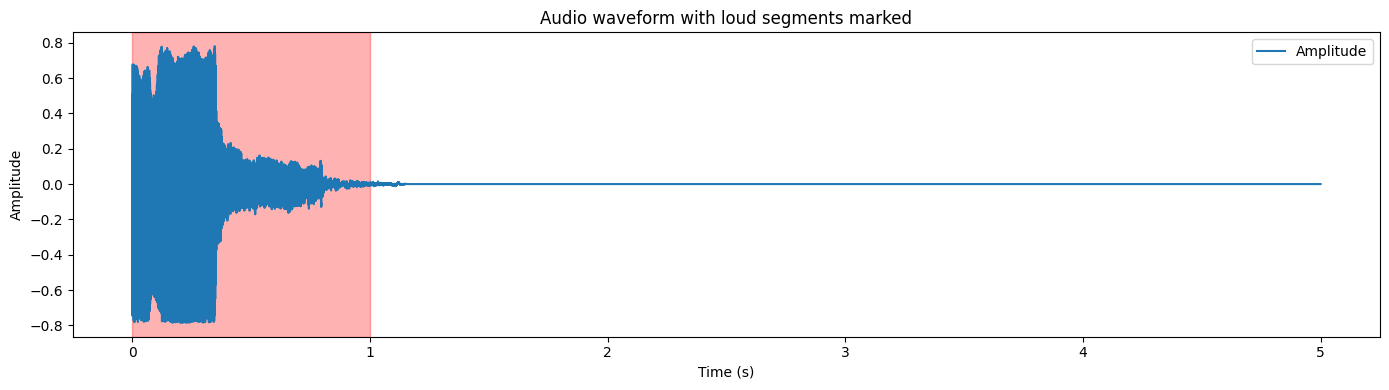

In [366]:
time_axis = np.linspace(0, len(audio) / sr, len(audio))

plt.figure(figsize=(14, 4))
plt.plot(time_axis, audio, label="Amplitude")
plt.title("Audio waveform with loud segments marked")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Corrected red span drawing
for i, (out, _, _) in enumerate(list_result):
    if out == 1:
        start_time = i * 0.5
        end_time = start_time + SEGMENT_DURATION / SAMPLE_RATE
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)

plt.tight_layout()
plt.legend()
plt.show()